## SEIRS Model - Adaptive Iterative Sequential Data-Consistent Parameter Estimation 

**Problem description**:

The SEIRS model describes the spread of a disease in a population fixed to $N$ individuals over time $t$. Furthermore, the model divides the population into four categories, called "S", "E", "I", and "R". The extra "S" at the end usually means we include the loss of immunity.
- "S" consists of individuals who are susceptible to the disease being modeled.
- "E" consists of individuals who are exposed to the disease. Diseases (like COVID-19) often have an incubation period or a latency period and this category accommodates it. (The SIR model does not have this category.)
- "I" consists of individuals infected with the disease and are capable of infecting others.
- "R" consists of individuals who can be removed from the system, e.g., because they have gained immunity to the disease, or because they have succumbed to the disease.

The SEIR model, like many other epidemiological models depends on particular parameters, which are the following :
 - $\beta>0$ The rate of contraction of the disease (transmission parameter)
 - $ \sigma >0$ The incubation rate i.e. the rate at which exposed hosts become infected
 - $\gamma>0$ : The mean recovery rate
 - $\xi>0$ : The loss of immunity rate. 
 
Individual $S$ becomes infected after positive contact with an $I$ individual. However, he develops immunity to the disease : he leaves $I$ category at a $\gamma$ cure rate. However with a rate $\xi$, they may lose immunity to the disease and rejoin the susceptible population $S$.

**Model Assumptions**

- Model is deterministic
- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time.
- The rate of infected individuals leaving category $I$ is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N=S+E+I+R$ is constant.
- Note constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

This is the system of equations of the model :

The total population $N$ in the system (the sum of individuals in all categories) is likely to be quite large. Instead of working with such large numbers, let us divide each side of each equation by $\mathbf{N}$ and work instead with the proportions
$$
s=\frac{S}{N}, \quad e=\frac{E}{N}, \quad i=\frac{I}{N}, \quad r=\frac{R}{N} .
$$
The equivalent ODE system to be solved for the unknown functions $s(t), e(t), i(t)$, and $r(t)$, has now become
$$
\begin{aligned}
& \frac{d s}{d t}=-\beta i s  + \xi r\\
& \frac{d e}{d t}=\beta i s-\sigma e \\
& \frac{d i}{d t}=\sigma e-\gamma i \\
& \frac{d r}{d t}=\gamma i - \xi r
\end{aligned}
$$
When supplemented with some initial conditions, say
$$
s(0)=0.99, \quad e(0)=0.01, \quad i(0)=0, \quad r(0)=0
$$
This is the formulation of the Initial Value Probelm we wish to solve. Note that the above initial conditions correspond to a starting scenario where just $1 \%$ of the population is exposed.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydci.examples import seirs
import importlib
from pydci.log import enable_log, disable_log
from pydci.utils import get_l2_errs, set_seed

importlib.reload(seirs)


SEIRS_PARAM_MINS = 4 * [0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0
    / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,  # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1 * 365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}

## Problem Set-Up

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

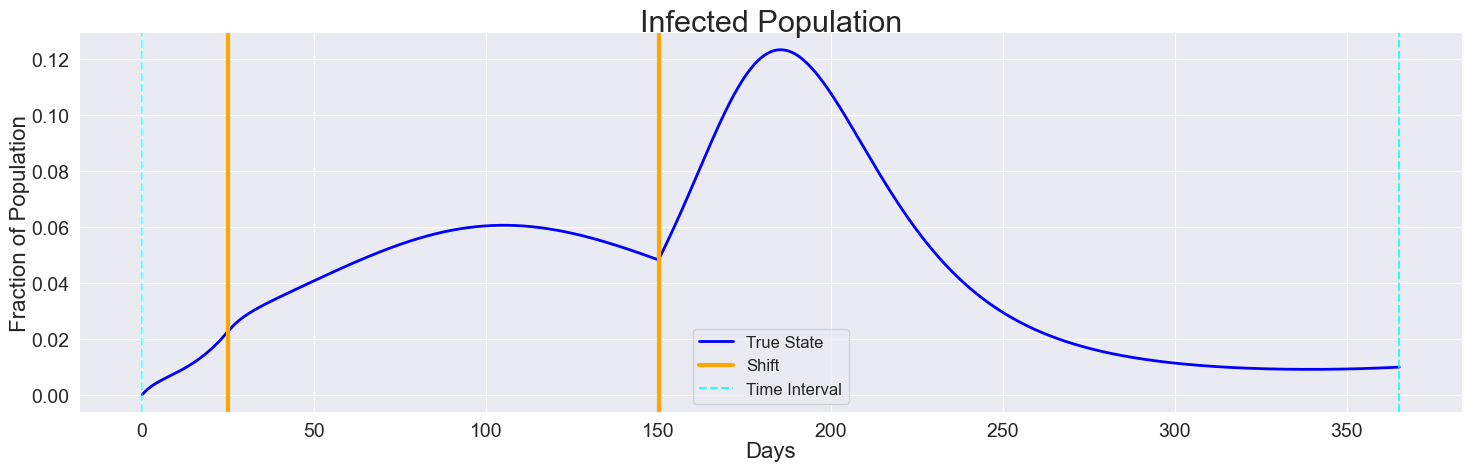

In [2]:
full_sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)
# pi_in, samples = full_sr.get_uniform_initial_samples(num_samples=1, scale=0.1)
res = full_sr.get_data(t0=0.0, tf=total_time)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
full_sr.plot_infected(plot_samples=False, plot_measurements=False, ax=ax)

# Online Iterative

In [11]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)

In [12]:
from pydci.log import logger
from pydci.utils import get_search_combinations
import pydci.consistent_bayes.OnlineSequential as os
import importlib

importlib.reload(os)
prob = os.OnlineSequential(
    sr,
    time_step=7,
)
enable_log(level='ERROR', filter='pydci.consistent_bayes.OnlineSequential')
prob.solve(
    num_its=52,
    max_t=None,
    num_samples=1000,
    max_sample_size=None,
    samples_inc=None,
    time_step=7,
    exp_thresh=0.2,
    kl_thresh=3.0,
    min_eff_sample_size=0.9,
    num_tries_per_it=2,
    sampling_args={
        "dist": "uniform",
        "scale": 1.0,
    },
    solver_args=dict(
        pca_range=[2],
        split_range=[1],
        all_data=True,
    ),
    make_plots=False,
    seed=2023,
    reset_model=True,
    reset_samples=False,
)

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

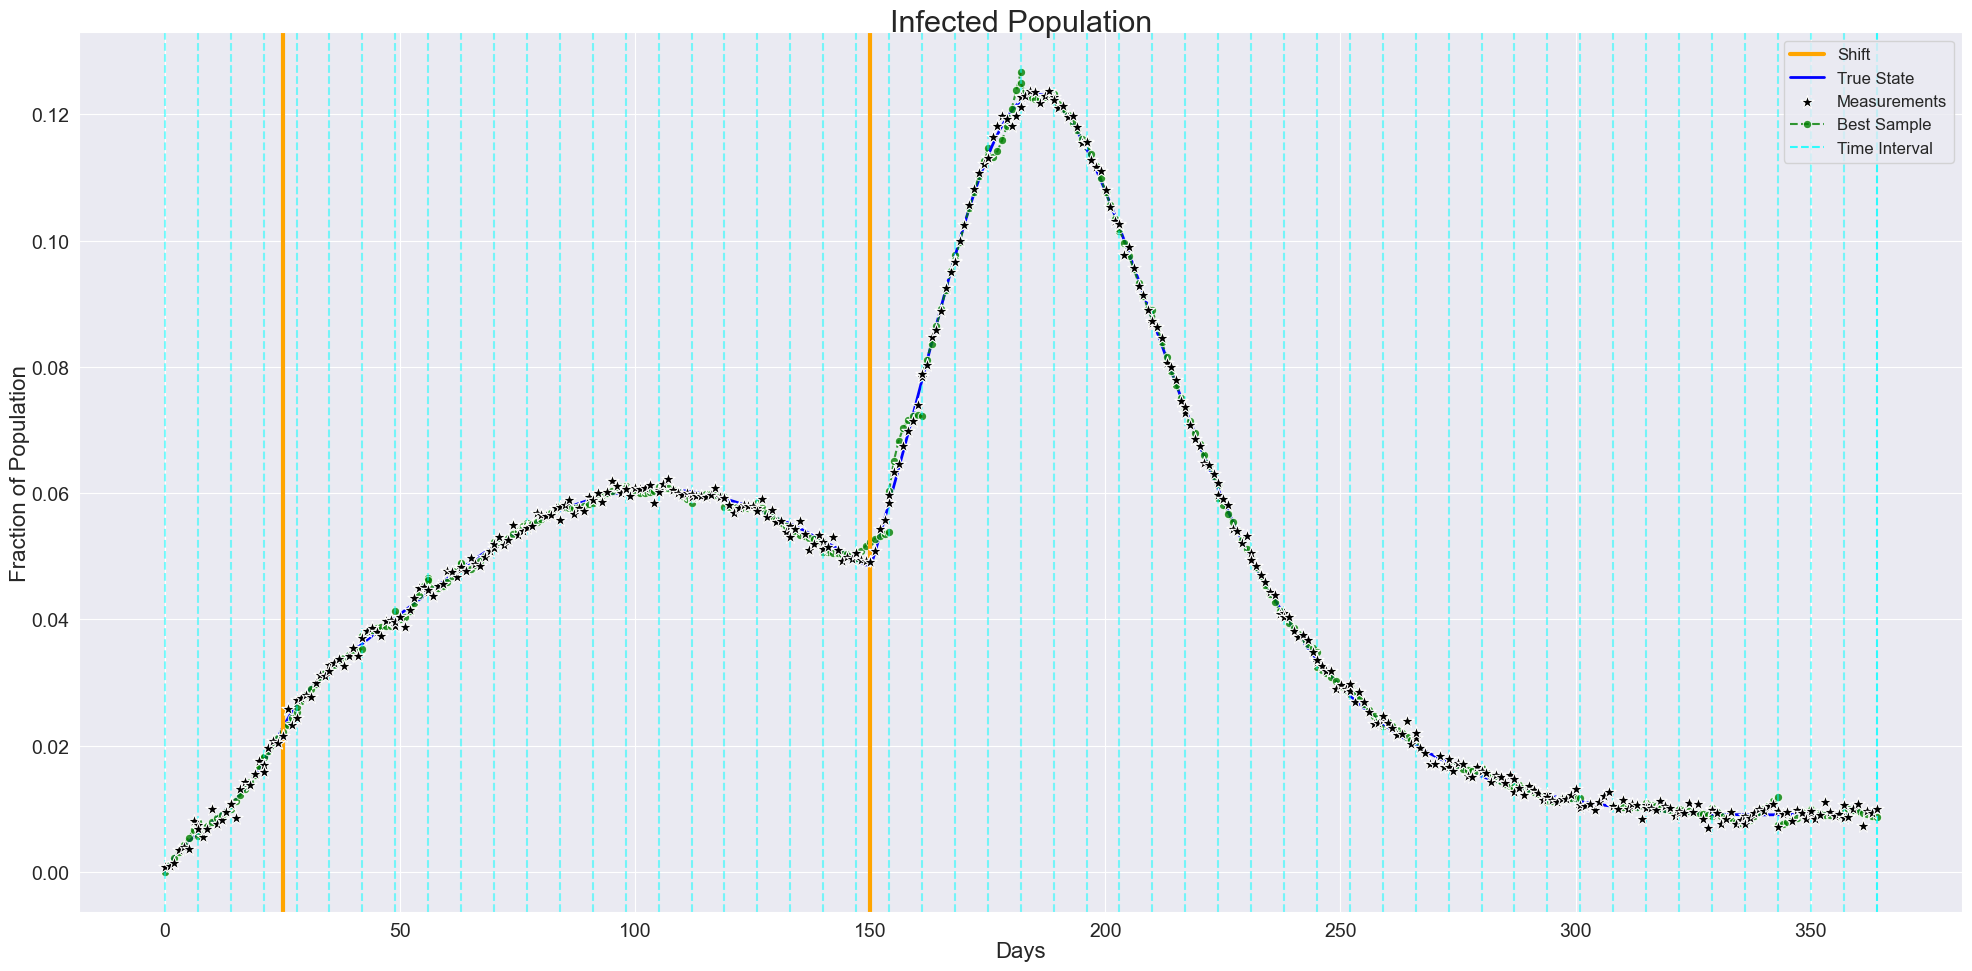

In [13]:
prob.model.plot_infected(figsize=(20,10), n_samples=0)

In [13]:
pd.concat(prob.it_results).dropna()

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,search_index,predict_delta,within_thresh,closest,max_kl,min_kl,num_samples,weighted,data_idx,num_splits
0,1.127005,0.935007,0.149786,0.169547,0.085554,0.004037,501.0,"[0, 1]","range(0, 8)",0.0,0.127005,True,True,True,True,1000,0,1,1.0
0,0.906958,2.217544,0.393196,0.121801,0.125555,0.004205,344.0,"[0, 1]","range(0, 8)",0.0,0.093042,True,True,True,True,1000,1,2,1.0
0,1.014802,2.584986,0.330178,0.092431,0.081437,0.004229,433.0,"[0, 1]","range(0, 8)",0.0,0.014802,True,True,True,True,1000,0,3,1.0
0,1.050305,2.955569,0.165447,0.226006,0.134384,0.002413,646.0,"[0, 1]","range(0, 8)",0.0,0.050305,True,True,True,True,1000,0,4,1.0
0,1.070016,1.158637,0.176784,0.227394,0.129973,-0.000020,589.0,"[0, 1]","range(0, 8)",0.0,0.070016,True,True,True,True,1000,0,6,1.0
0,0.999913,1.331474,0.191594,0.210212,0.127681,0.001698,206.0,"[0, 1]","range(0, 8)",0.0,0.000087,True,True,True,True,1000,0,7,1.0
0,1.132611,1.694646,0.158085,0.209873,0.113954,0.001556,764.0,"[0, 1]","range(0, 8)",0.0,0.132611,True,True,True,True,1000,1,8,1.0
0,1.044062,0.781703,0.105486,0.170777,0.078073,0.004306,718.0,"[0, 1]","range(0, 8)",0.0,0.044062,True,True,True,True,1000,0,9,1.0
0,1.001437,0.860350,0.118099,0.153835,0.079062,0.003889,511.0,"[0, 1]","range(0, 8)",0.0,0.001437,True,True,True,True,1000,0,11,1.0
0,0.956016,0.670194,0.118099,0.153835,0.079062,0.003889,511.0,"[0, 1]","range(0, 8)",0.0,0.043984,True,True,True,True,1000,1,12,1.0


[<AxesSubplot: xlabel='Iteration', ylabel='$\\mathbb{E}(r)$'>,
 <AxesSubplot: xlabel='Iteration', ylabel='$\\Delta \\mathrm{KL}()$'>]

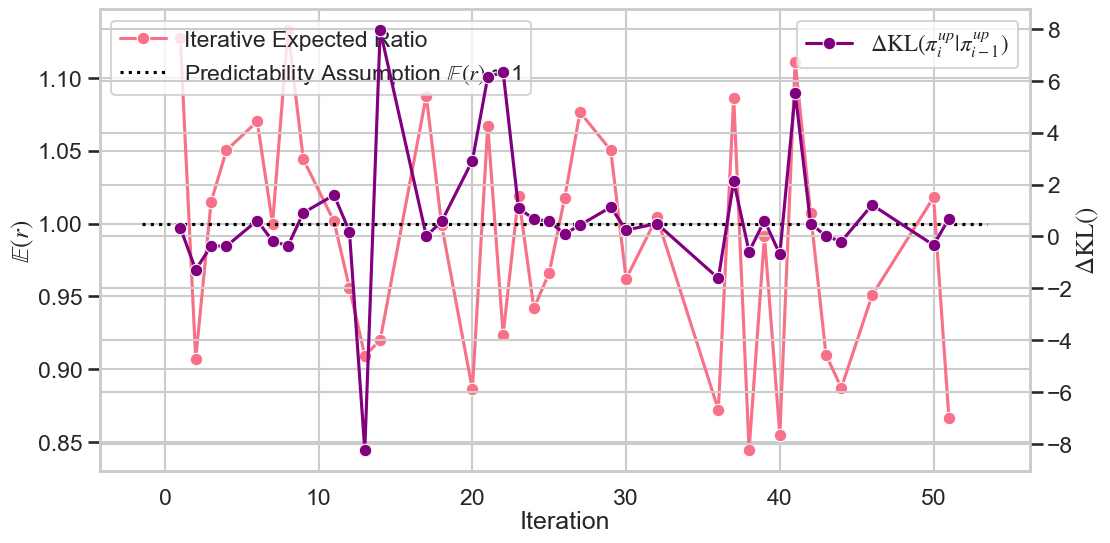

In [9]:
prob.joint_metrics_plot(y2='kl_delta')

# First Shift

In [7]:
first_shift = [0, 80]

(-0.006221332157063161, 0.08)

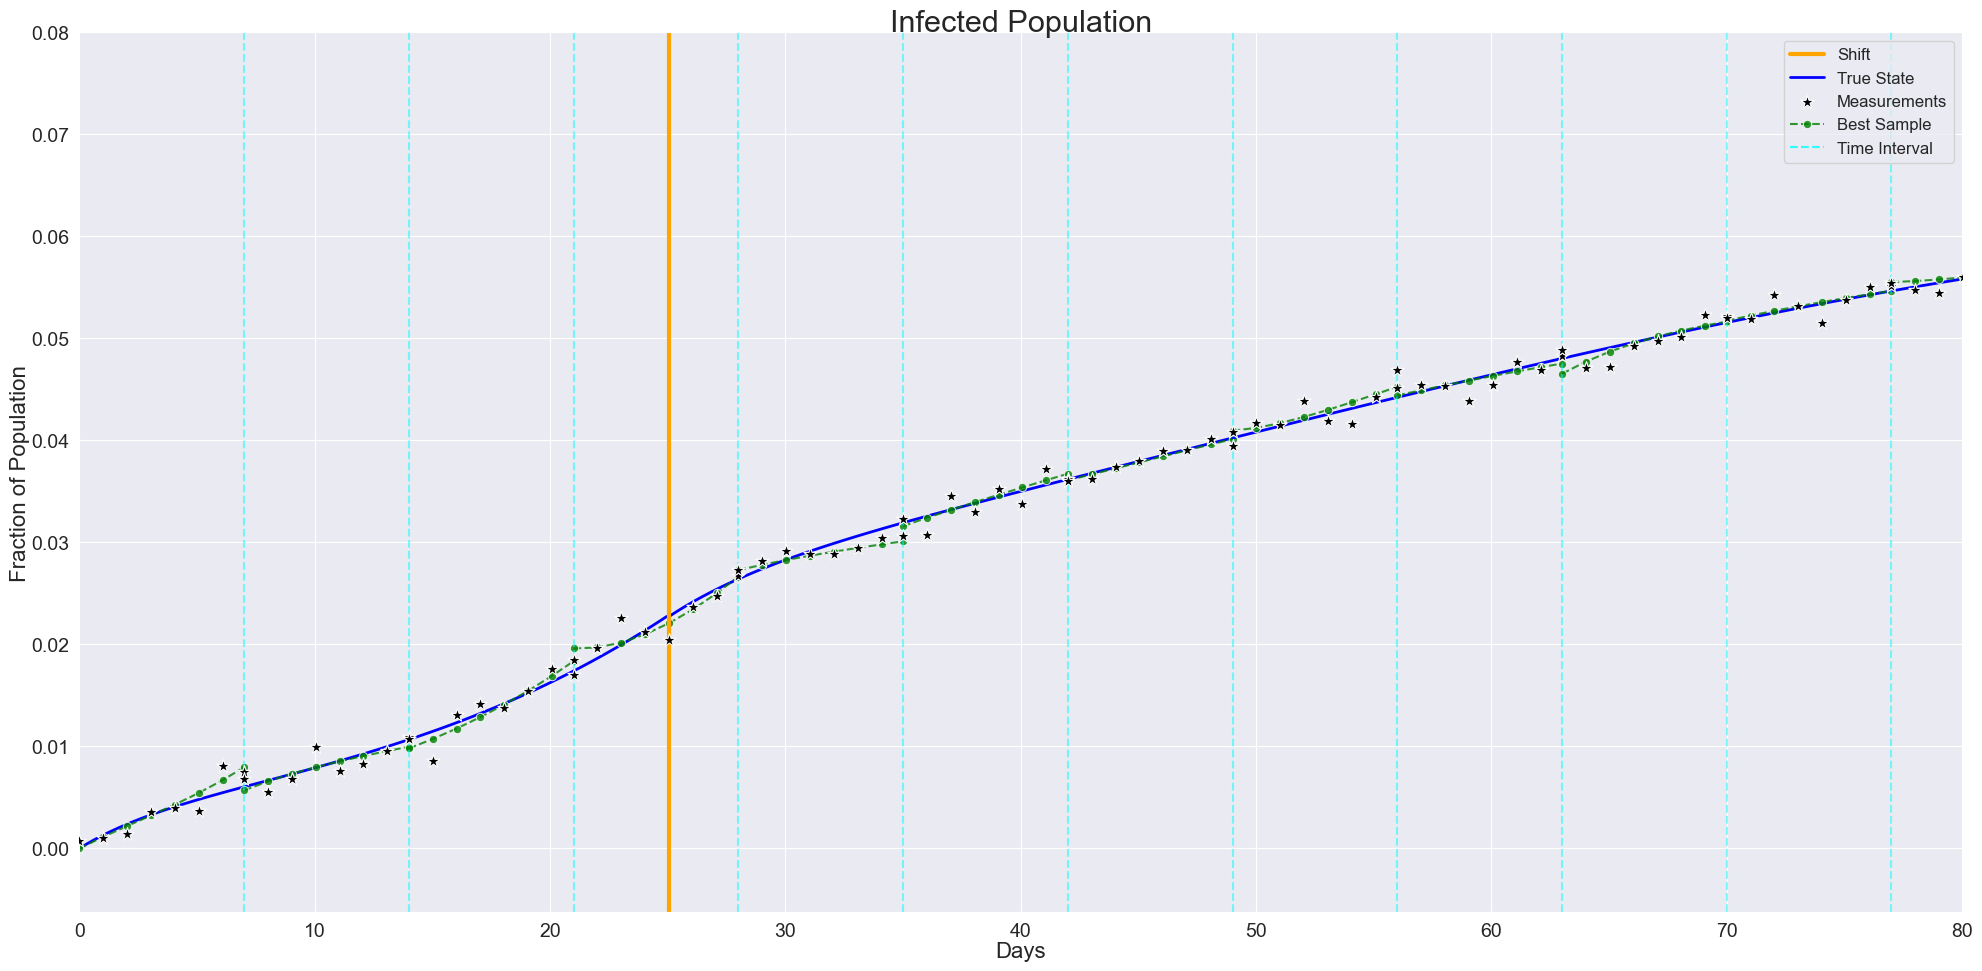

In [8]:
ax = sr.plot_infected(plot_samples=True, n_samples=0, figsize=(20, 10))
ax.set_xlim(first_shift)
ax.set_ylim([ax.get_ylim()[0], 0.08])

/Users/carlos/.mm/envs/chg-dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1134: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_data.insert(0, var, comp_col)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 prob.joint_metrics_plot()                                                                    │
│   2                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                      ax = <AxesSubplot: title={'center': 'Infected Population'},             │ │
│ │                           xlabel='Days', ylabel='Fraction of Population'>                    │ │
│ │         data_chunk_size = 7                                                                  │ │
│ │             disable_log = <function disable_log at 0x151bdb880>                              │ │
│ │              enable_log = <function enable_log at 0x151bdb7e0>                               │ │
│ │                    exit = <IPython.core.autocall.ZMQExitAutocall object at 0x12070d5d0>      │ │
│ │                     fig = <Figure size 1500x500 with 1 Axes>                                 │ │
│ │             first_shift = [0, 80]                                                            │ │
│ │                 full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1508574d0>            │ │
│ │             get_ipython = <bound method InteractiveShell.get_ipython of                      │ │
│ │                           <ipykernel.zmqshell.ZMQInteractiveShell object at 0x120705c10>>    │ │
│ │             get_l2_errs = <function get_l2_errs at 0x151bfcb80>                              │ │
│ │ get_search_combinations = <function get_search_combinations at 0x151bfcc20>                  │ │
│ │               importlib = <module 'importlib' from                                           │ │
│ │                           '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__… │ │
│ │                      In = [                                                                  │ │
│ │                           │   '',                                                            │ │
│ │                           │   'import numpy as np\nfrom matplotlib import pyplot as          │ │
│ │                           plt\nfrom pydci.examples impo'+1453,                               │ │
│ │                           │   'full_sr = seirs.SEIRSModel(\n    lam_true=SEIRS_P1,\n         │ │
│ │                           param_shifts=param_shifts'+383,                                    │ │
│ │                           │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size =        │ │
│ │                           7\nn_chunks = int(total_time'+231,                                 │ │
│ │                           │   'from pydci.log import logger\nfrom pydci.utils import         │ │
│ │                           get_search_combinations\nimp'+704,                                 │ │
│ │                           │   'prob.model.plot_infected(figsize=(20,10), n_samples=0)',      │ │
│ │                           │   "prob.joint_metrics_plot(y1='kl_delta')",                      │ │
│ │                           │   'first_shift = [0, 80]',                                       │ │
│ │                           │   'ax = sr.plot_infected(plot_samples=True, n_samples=0,         │ │
│ │                           figsize=(20, 10))\nax.set_x'+54,                                   │ │
│ │                           │   'prob.joint_metrics_plot()'                                    │ │
│ │                           ]                                                                  │ │
│ │                  logger = <loguru.logger handlers=[(id=1,

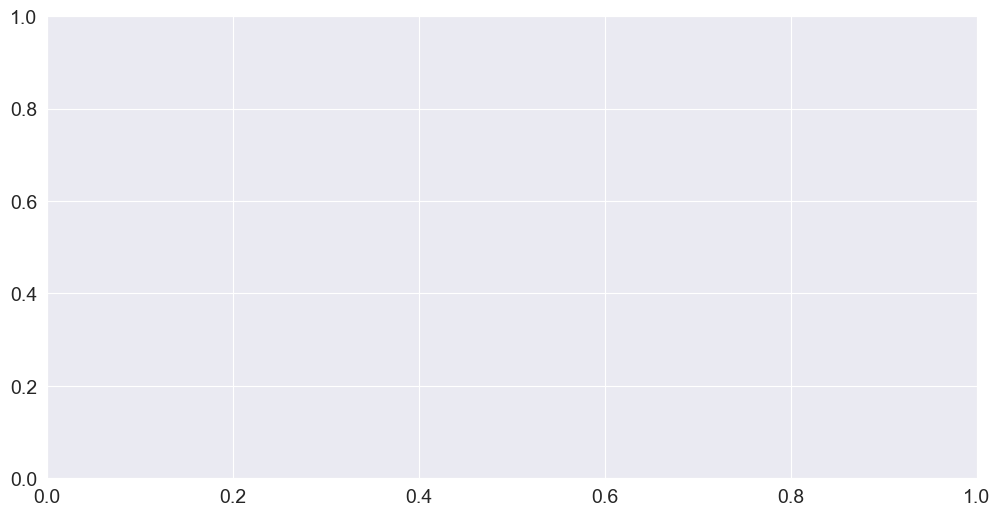

In [9]:
prob.joint_metrics_plot()

In [33]:
prob.solve(
    num_its=1,
    max_t=None,
    num_samples=1000,
    max_sample_size=2000,
    samples_inc=None,
    time_step=7,
    exp_thresh=0.1,
    kl_thresh=3.0,
    min_eff_sample_size=1.0,
    tries_per_it=2,
    sampling_args={
        "dist": "uniform",
        "scale": 1.0,
    },
    solver_args=dict(
        pca_range=[1],
        split_range=[1],
        all_data=True,
    ),
    make_plots=True,
    reset_model=False,
    reset_samples=False,
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 prob.solve(                                                                                 │
│    2 │   num_its=1,                                                                              │
│    3 │   max_t=None,                                                                             │
│    4 │   num_samples=1000,                                                                       │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                      ax = <AxesSubplot: title={'center': 'Infected Population'},             │ │
│ │                           xlabel='Days', ylabel='Fraction of Population'>                    │ │
│ │         data_chunk_size = 7                                                                  │ │
│ │             disable_log = <function disable_log at 0x15b457920>                              │ │
│ │              enable_log = <function enable_log at 0x15b457880>                               │ │
│ │                    exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11030d750>      │ │
│ │                     fig = <Figure size 1500x500 with 1 Axes>                                 │ │
│ │                 full_sr = <pydci.examples.seirs.SEIRSModel object at 0x15c6ad890>            │ │
│ │             get_ipython = <bound method InteractiveShell.get_ipython of                      │ │
│ │                           <ipykernel.zmqshell.ZMQInteractiveShell object at 0x107df6310>>    │ │
│ │             get_l2_errs = <function get_l2_errs at 0x15b480c20>                              │ │
│ │ get_search_combinations = <function get_search_combinations at 0x15b480cc0>                  │ │
│ │               importlib = <module 'importlib' from                                           │ │
│ │                           '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__… │ │
│ │                      In = [                                                                  │ │
│ │                           │   '',                                                            │ │
│ │                           │   'import numpy as np\nfrom matplotlib import pyplot as          │ │
│ │                           plt\nfrom pydci.examples impo'+1453,                               │ │
│ │                           │   'full_sr = seirs.SEIRSModel(\n    lam_true=SEIRS_P1,\n         │ │
│ │                           param_shifts=param_shifts'+383,                                    │ │
│ │                           │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size =        │ │
│ │                           7\nn_chunks = int(total_time'+231,                                 │ │
│ │                           │   'from pydci.log import logger\nfrom pydci.utils import         │ │
│ │                           get_search_combinations\nimp'+705,                                 │ │
│ │                           │   'import numpy as np\nfrom matplotlib import pyplot as          │ │
│ │                           plt\nfrom pydci.examples impo'+1453,                               │ │
│ │                           │   'full_sr = seirs.SEIRSModel(\n    lam_true=SEIRS_P1,\n         │ │
│ │                           param_shifts=param_shifts'+383,                                    │ │
│ │                           │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size =        │ │
│ │                           7\nn_chunks = int(total_time'+231,                                 │ │
│ │                           │   'from pydci.log import logg

[08/11/23 11:23:20] INFO     Starting from iteration 2                                      ]8;id=998007;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=164194;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#766\766]8;;\

                    DEBUG    make_plots: range(0, 10)                                       ]8;id=964790;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=212161;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#784\784]8;;\

                    INFO     Starting online solve with 1000 samples                        ]8;id=123541;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=757282;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#788\788]8;;\

                    DEBUG    Getting measurements over time window 14.0 to 21.0             ]8;id=446717;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=868582;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#794\794]8;;\

                    INFO     Getting data for model from 14.0 to 21.0                                  ]8;id=97718;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=105854;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#388\388]8;;\

                    DEBUG    Shapes: (70, 1), (70, 4), (70,)                                           ]8;id=741135;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=872994;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#403\403]8;;\

                    DEBUG    Starting solves for iteration 2                                ]8;id=176104;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=886425;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#806\806]8;;\

                    INFO     Effective sample size: 853                                     ]8;id=906066;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=955891;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#602\602]8;;\

                    INFO     Re-setting weights: 853 < 1.0).                                ]8;id=310488;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=182600;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#606\606]8;;\

                    INFO     Re-sampling from pi_up_1                                       ]8;id=415902;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=313736;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#610\610]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=694242;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=638328;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#635\635]8;;\

                    INFO     Beginning forward solve from 14.0 to 21.0                                 ]8;id=668377;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=105049;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#456\456]8;;\

                    DEBUG    Starting fresh simulation for 1000                                        ]8;id=229414;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=775640;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#468\468]8;;\

[08/11/23 11:23:21] DEBUG    Solving using 1000 samples. Args: {'pca_range': [1],           ]8;id=40801;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=598975;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#649\649]8;;\
                             'split_range': [1], 'all_data': True, 'weights': None,                                
                             'search_exp_thresh': 0.1}                                                             

                    INFO     Searching through combinations:                         ]8;id=350100;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=935403;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#172\172]8;;\
                                exp_thresh  pca_components                  pca_mask                               
                             pca_splits                                                                            
                             0         0.1               1  (0, 1, 2, 3, 4, 5, 6, 7)                               
                             1                                                                                     

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.1,         ]8;id=626810;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=737708;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#204\204]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 8),                                         
                             'pca_splits': 1, 'fail_on_partial': True, 'weights':                                  
                             None}                                                                                 

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=999010;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=291841;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=468894;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=407566;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.17874753e+00 1.55060740e+00 2.77032580e-01       ]8;id=709079;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=45739;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.60444474e-03]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=778526;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=269097;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=847876;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=402780;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Search results:                                         ]8;id=733003;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=777720;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#243\243]8;;\
                                     e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2                                
                             lam_MUD_3  MUD_idx  \                                                                 
                             0  0.995229  0.907312   0.161877   0.116471   0.044858                                
                             0.002977      272                                                                     
                                                                                                                   
                               pca_components     pca_mask  num_splits  search_index                               
                             predict_delta  \                                                                      
                             0            [0]  range(0, 8)           1             0                               
                             0.004771                                                                              
                                                                                                                   
                                within_thresh  closest  max_kl  min_kl                                             
                             0           True     True    True    True                                             

                    INFO     Solved using 1000 samples:                                     ]8;id=179886;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=860214;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#685\685]8;;\
                             Result:        e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2                         
                             lam_MUD_3  MUD_idx  \                                                                 
                             0  0.995229  0.907312   0.161877   0.116471   0.044858                                
                             0.002977      272                                                                     
                                                                                                                   
                               pca_components     pca_mask  num_splits  search_index                               
                             predict_delta  \                                                                      
                             0            [0]  range(0, 8)           1             0                               
                             0.004771                                                                              
                                                                                                                   
                                within_thresh  closest  max_kl  min_kl                                             
                             0           True     True    True    True                                             
                             Search Results        e_r        kl  lam_MUD_0  lam_MUD_1                             
                             lam_MUD_2  lam_MUD_3  MUD_idx  \                                                      
                             0  0.995229  0.907312   0.161877   0.116471   0.044858                                
                             0.002977      272                                                                     
                                                                                                                   
                               pca_components     pca_mask  num_splits  search_index                               
                             predict_delta  \                                                                      
                             0            [0]  range(0, 8)           1             0                               
                             0.004771                                                                              
                                                                                                                   
                                within_thresh  closest  max_kl  min_kl  num_samples                                
                             weighted                                                                              
                             0           True     True    True    True         1000                                
                             False                                                                                 

                    INFO     Finished solved: SOLVED. Results:                              ]8;id=984877;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=361659;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#689\689]8;;\
                                     e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2                                
                             lam_MUD_3  MUD_idx  \                                                                 
                             0  0.995229  0.907312   0.161877   0.116471   0.044858                                
                             0.002977      272                                                                     
                                                                                                                   
                               pca_components     pca_mask  num_splits  search_index                               
                             predict_delta  \                                                                      
                             0            [0]  range(0, 8)           1             0                               
                             0.004771                                                                              
                                                                                                                   
                                within_thresh  closest  max_kl  min_kl  num_samples                                
                             weighted                                                                              
                             0           True     True    True    True         1000                                
                             False                                                                                 

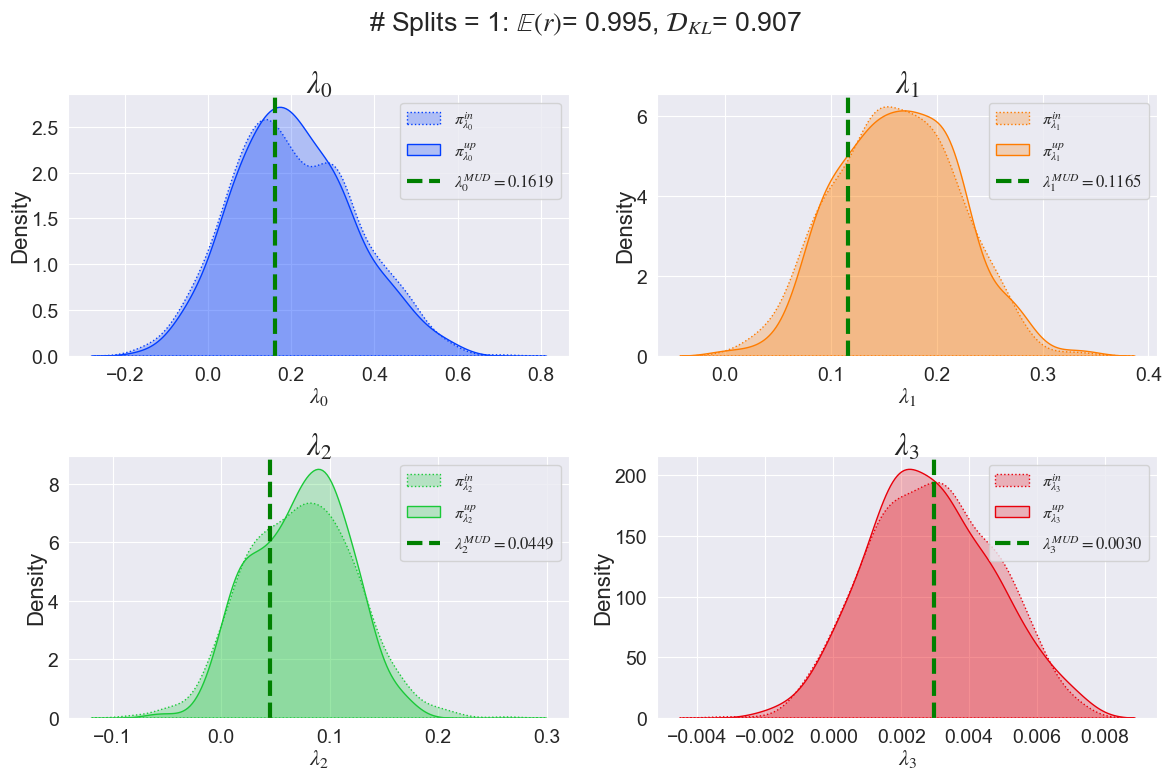

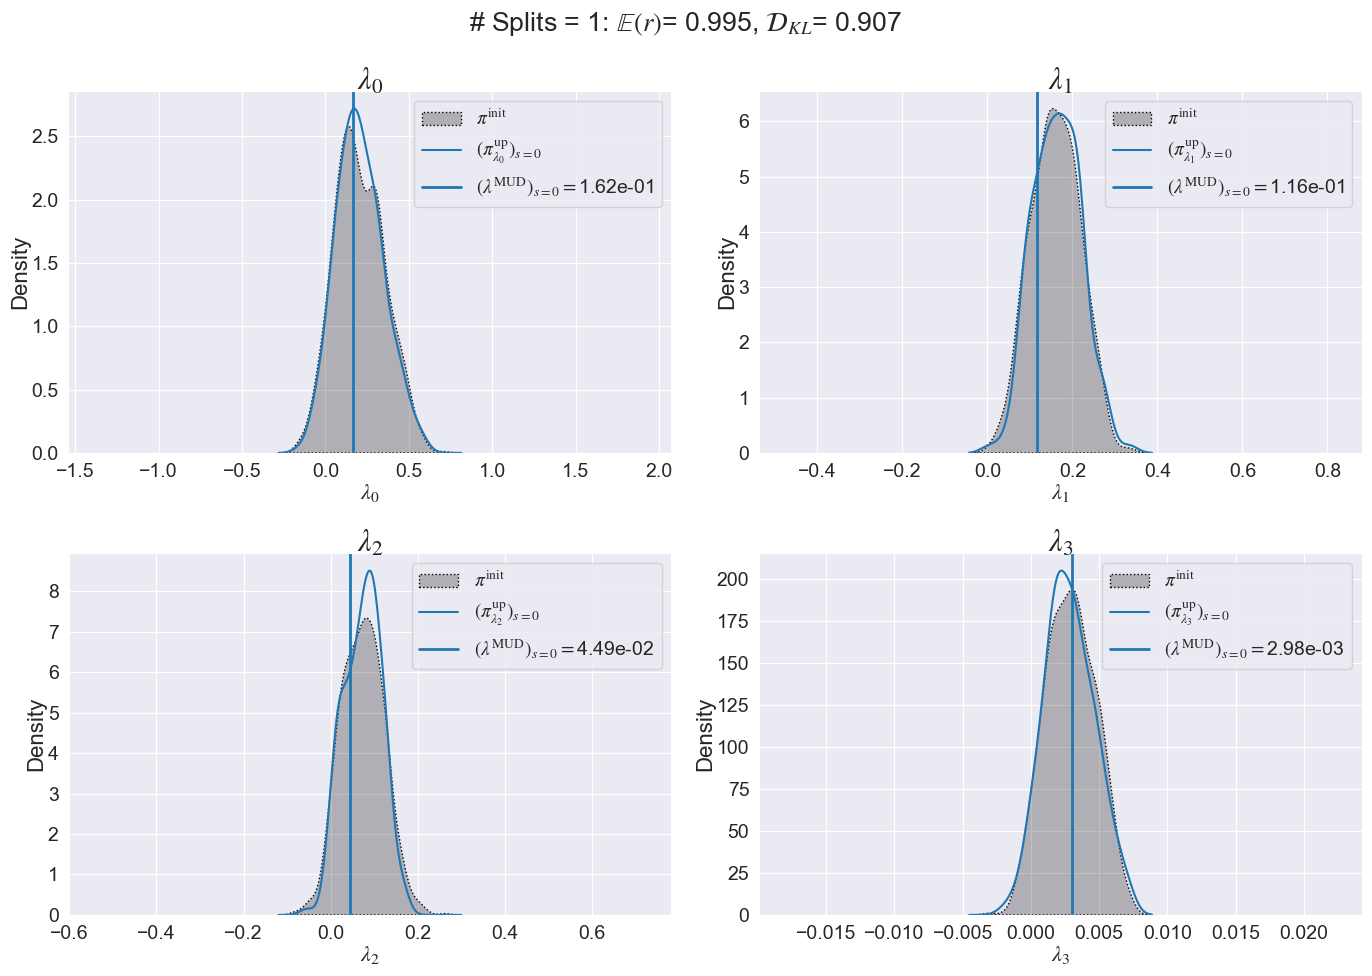

[08/11/23 11:23:25] INFO             e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2         ]8;id=138960;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=925599;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#835\835]8;;\
                             lam_MUD_3  MUD_idx  \                                                                 
                             0  0.995229  0.907312   0.161877   0.116471   0.044858                                
                             0.002977      272                                                                     
                                                                                                                   
                               pca_components     pca_mask  num_splits  search_index                               
                             predict_delta  \                                                                      
                             0            [0]  range(0, 8)           1             0                               
                             0.004771                                                                              
                                                                                                                   
                                within_thresh  closest  max_kl  min_kl                                             
                             0           True     True    True    True                                             

                    DEBUG    Getting measurements over time window 21.0 to 35.0             ]8;id=61412;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=305474;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#794\794]8;;\

                    INFO     Getting data for model from 21.0 to 35.0                                  ]8;id=5005;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=353949;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#388\388]8;;\

                    DEBUG    Shapes: (140, 1), (140, 4), (140,)                                        ]8;id=165271;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=655208;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#403\403]8;;\

                    DEBUG    Starting solves for iteration 3                                ]8;id=120776;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=381780;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#806\806]8;;\

                    INFO     Effective sample size: 825                                     ]8;id=191184;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=746791;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#602\602]8;;\

                    INFO     Re-setting weights: 825 < 1.0).                                ]8;id=637923;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=653536;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#606\606]8;;\

                    INFO     Re-sampling from pi_up_2                                       ]8;id=513951;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=280537;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#610\610]8;;\

                    INFO     Advancing forward model for 1000 samples                       ]8;id=505810;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=40860;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#635\635]8;;\

                    INFO     Beginning forward solve from 21.0 to 35.0                                 ]8;id=408919;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=399489;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#456\456]8;;\

                    DEBUG    Starting fresh simulation for 1000                                        ]8;id=307849;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=639942;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#468\468]8;;\

[08/11/23 11:23:26] DEBUG    Solving using 1000 samples. Args: {'pca_range': [1],           ]8;id=815058;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py\OnlineSequential.py]8;;\:]8;id=150847;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OnlineSequential.py#649\649]8;;\
                             'split_range': [1], 'all_data': True, 'weights': None,                                
                             'search_exp_thresh': 0.1}                                                             

                    INFO     Searching through combinations:                         ]8;id=393394;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=224259;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#172\172]8;;\
                                exp_thresh  pca_components  \                                                      
                             0         0.1               1                                                         
                                                                                                                   
                                                                         pca_mask                                  
                             pca_splits                                                                            
                             0  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...                                  
                             1                                                                                     

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.1,         ]8;id=31631;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=540257;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#204\204]8;;\
                             'pca_components': 1, 'pca_mask': range(0, 15),                                        
                             'pca_splits': 1, 'fail_on_partial': True, 'weights':                                  
                             None}                                                                                 

                    INFO     Iteration 0: Solving using (range(0, 15), [0])                ]8;id=383779;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=951465;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=39175;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=77122;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [10.43344976  3.86208978  0.66570061  0.05285296]   ]8;id=483326;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=600646;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=610601;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=574745;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=149343;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=90434;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.15616399287639293 > 0.1 - Stopping             ]8;id=658858;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=64575;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=385300;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=495763;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#211\211]8;;\
                             within exp_thresh                                                                     

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py:206 in solve     │
│                                                                                                  │
│   203 │   │   │   │   ))                                                                         │
│   204 │   │   │   │   logger.debug(f"Attempting solve with args: {args}")                        │
│   205 │   │   │   │   try:                                                                       │
│ ❱ 206 │   │   │   │   │   prob.solve(**args, state_extra={"search_index": idx})                  │
│   207 │   │   │   │   except ZeroDivisionError or KDEError or LinAlgError as e:                  │
│   208 │   │   │   │   │   logger.error(f"Failed: Ill-posed problem: {e}")                        │
│   209 │   │   │   │   except RuntimeError as r:                                                  │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │           all_data = True                                                                    │ │
│ │        all_results = []                                                                      │ │
│ │ all_search_results = []                                                                      │ │
│ │                 am = ['closest', 'min_kl', 'max_kl']                                         │ │
│ │               args = {                                                                       │ │
│ │                      │   'exp_thresh': 0.1,                                                  │ │
│ │                      │   'pca_components': 1,                                                │ │
│ │                      │   'pca_mask': range(0, 15),                                           │ │
│ │                      │   'pca_splits': 1,                                                    │ │
│ │                      │   'fail_on_partial': True,                                            │ │
│ │                      │   'weights': None                                                     │ │
│ │                      }                                                                       │ │
│ │                bar = <alive_progress.core.progress.__AliveBarHandle object at 0x14033ead0>   │ │
│ │        best_method = 'closest'                                                               │ │
│ │    data_chunk_size = None                                                                    │ │
│ │         exp_thresh = 0.5                                                                     │ │
│ │    fail_on_partial = True                                                                    │ │
│ │                idx = 0                                                                       │ │
│ │         mask_range = None                                                                    │ │
│ │             max_nc = 5                                                                       │ │
│ │      max_num_combs = 20                                                                      │ │
│ │          pca_range = [1]                                                                     │ │
│ │              pi_in = None                                                                    │ │
│ │               prob = <pydci.consistent_bayes.OfflineSequential.OfflineSequential object at   │ │
│ │                      0x136c830d0>                                                            │ │
│ │              probs = []                                                                      │ │
│ │  search_exp_thresh = 0.1                                                                     │ │
│ │        search_list = [                                   

In [17]:
prob.solve(
    num_its=10,
    max_t=None,
    num_samples=1000,
    max_sample_size=1000,
    samples_inc=None,
    time_step=7,
    exp_thresh=0.1,
    kl_thresh=3.0,
    min_eff_sample_size=1.0,
    tries_per_it=2,
    sampling_args={
        "dist": "uniform",
        "scale": 1.0,
    },
    solver_args=dict(
        pca_range=[1],
        split_range=[1],
        all_data=True,
    ),
    make_plots=True,
    reset_model=False,
    reset_samples=False,
)

# OLD Code:

In [86]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)


set_seed(21)  # works well
# set_seed(2023) # Does not... why?
sgs, probs = sr.adaptive_online_iterative(
    np.arange(0, data_chunk_size * n_chunks + 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.8,
    weights=None,
)

Solving model sample set: |████▋               | ▂▄▆ 230/1000 [23%] in 0s (~0s, 

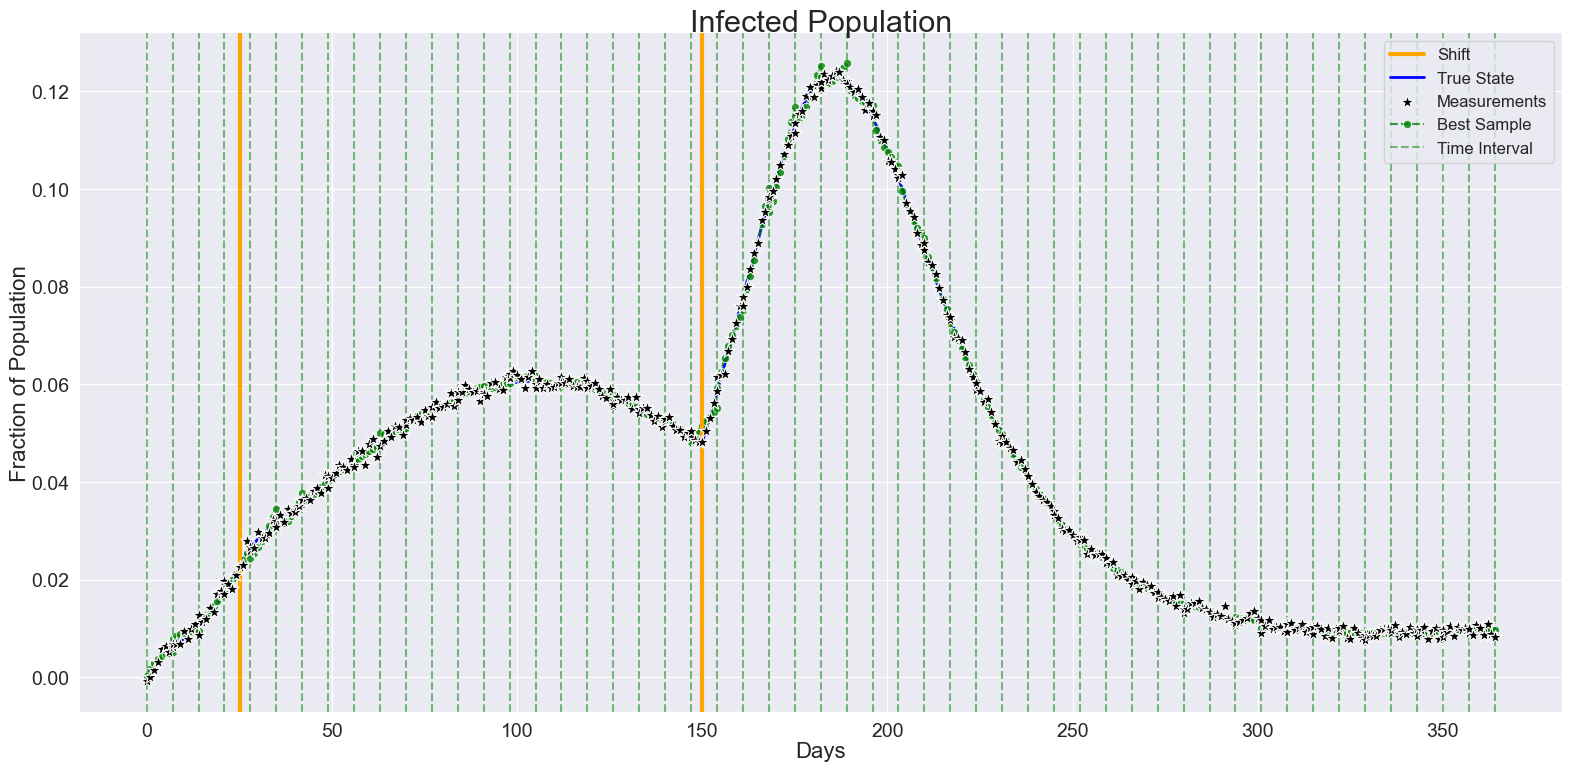

In [93]:
ax = sr.plot_infected(
    plot_measurements=True, plot_samples=True, n_samples=0, figsize=(16, 8)
)

## First Shift - "Flattening of the Curve"

In [88]:
first_shift_end = 100

(-0.007089759073479672, 0.08)

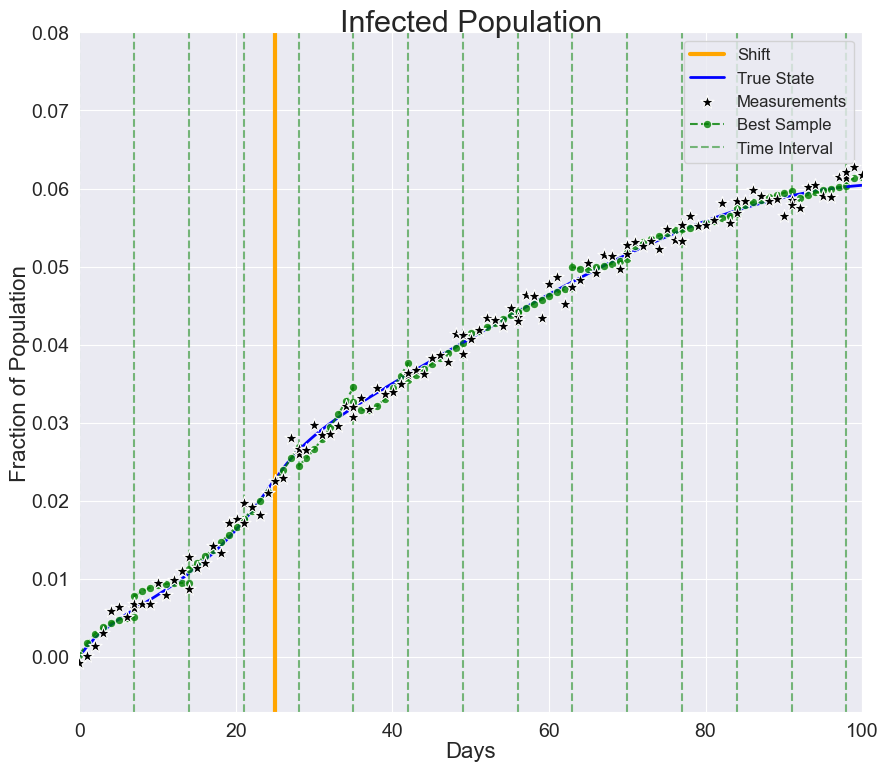

In [89]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([0, first_shift_end])
ax.set_ylim([ax.get_ylim()[0], 0.08])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

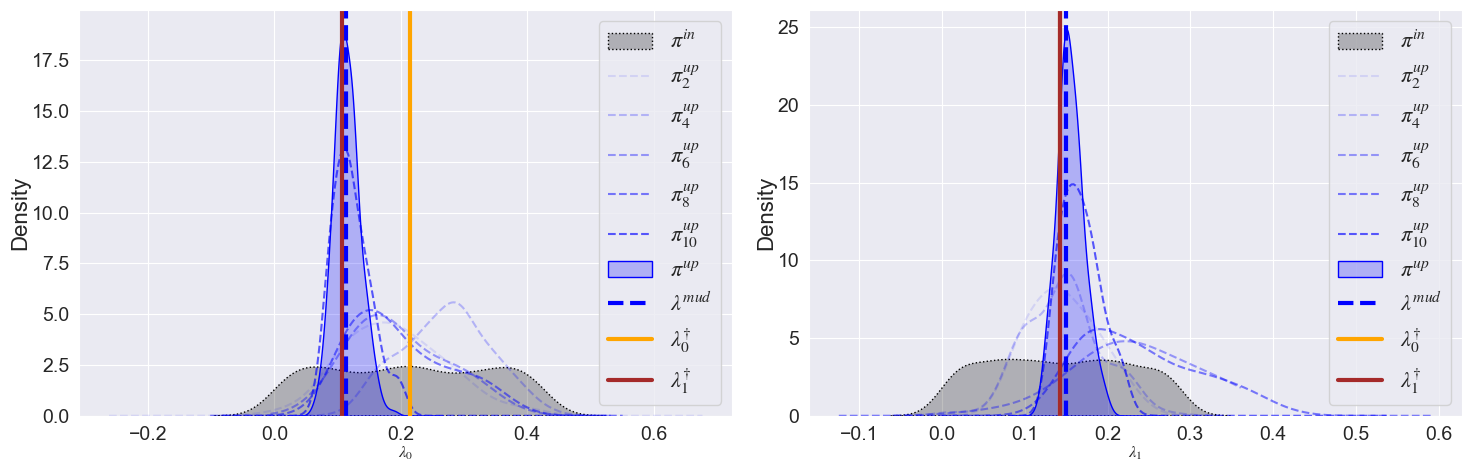

In [90]:
# TODO - Legend for parameter shift  ->
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sr.plot_param_density(
    probs,
    param_idx=0,
    idxs=np.arange(0, int(first_shift_end / 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[0],
)
sr.plot_param_density(
    probs,
    param_idx=1,
    idxs=np.arange(0, int(first_shift_end / 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[1],
)

## Second Shift - Mutation and "Second wave"

(120.0, 190.0)

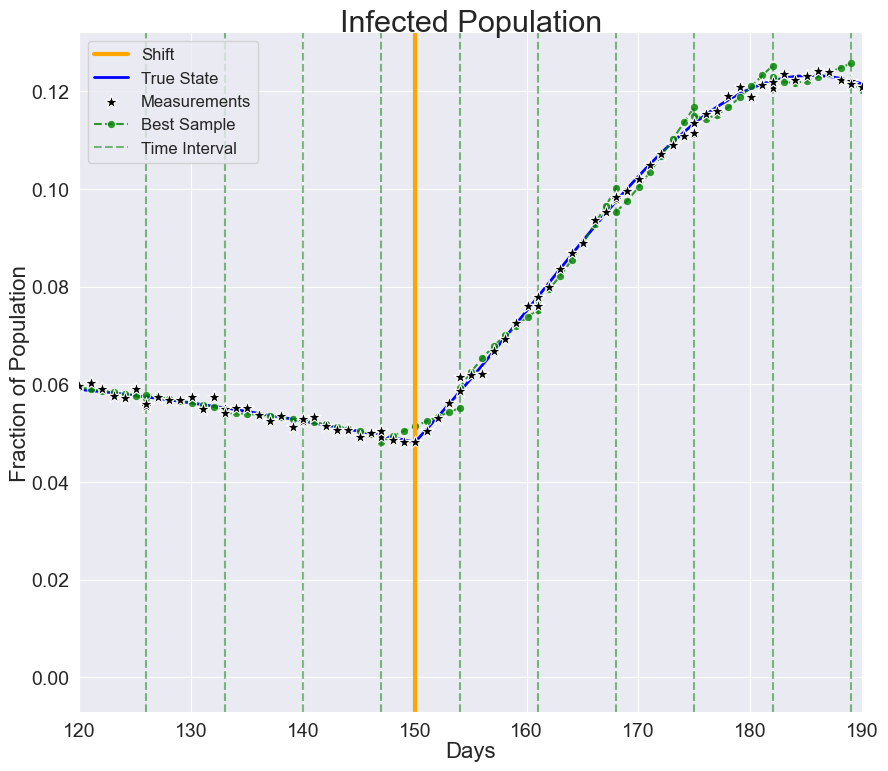

In [82]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([120, 190])